<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Знакомство-с-данными" data-toc-modified-id="Знакомство-с-данными-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Знакомство с данными</a></span></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LogisticRegression()" data-toc-modified-id="LogisticRegression()-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LogisticRegression()</a></span></li><li><span><a href="#DecisionTreeClassifier()" data-toc-modified-id="DecisionTreeClassifier()-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>DecisionTreeClassifier()</a></span></li><li><span><a href="#LGBMClassifier()" data-toc-modified-id="LGBMClassifier()-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>LGBMClassifier()</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Требуется обучить модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.

Построенная модель должна иметь значение метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузить и подготовить данные.
2. Обучить разные модели. 
3. Сделать выводы.

Для выполнения проекта применять *BERT* необязательно.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Знакомство с данными

Импортируем необходимые для работы библиотеки.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords as nltk_stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.utils import resample, shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from lightgbm import LGBMClassifier

nltk.download('averaged_perceptron_tagger')

RANDOM_STATE=42

import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 5.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Загрузим датафрейм и сохраним его в переменную. Познакомимся с данными.

In [2]:
data = pd.read_csv('/datasets/toxic_comments.csv')

In [3]:
# просмотрим первые строки датафрейма
data.head(10)

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
5,5,"""\n\nCongratulations from me as well, use the ...",0
6,6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,7,Your vandalism to the Matt Shirvington article...,0
8,8,Sorry if the word 'nonsense' was offensive to ...,0
9,9,alignment on this subject and which are contra...,0


In [4]:
# посмотрим общую информацию о датафрейме
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


Пропусков в предоставленном датафрейме нет, а тип данных столбцов соответствует содержимому.

In [5]:
# проверим наличие явных дубликатов
data.duplicated().sum()

0

Явные дубликаты отсутствуют.

In [6]:
# проверим соотношение позитивных и негативных комментариев в целевом признаке
data.toxic.value_counts(normalize=True)

toxic
0    0.898388
1    0.101612
Name: proportion, dtype: float64

В столбце целевого признака прослеживается существенный дисбаланс классов.

**Вывод**

В предоставленном датафрейме `159292` объекта. Пропусков нет, явных дубликатов также нет. Следует удалить неинформативный столбец `Unnamed: 0`, поскольку в нем просто дублируются индексы. Тексты комментариев на английском языке, судя по первым строкам, есть лишние символы (например, `"\nMore\n`, `"\n\nCongratulations`), некторые комментарии написаны в верхнем регистре. Мы обнаружили дисбаланс классов: в столбце целевого признака практически `90 %` объектов класса `0` и только `10 %` класса `1`. С этим нужно будет поработать при подготовке данных.

## Подготовка

Для начала удалим неинформативный столбец `Unnamed: 0`.

In [7]:
data = data.drop(['Unnamed: 0'], axis=1)

In [8]:
# проверим, что получилось
data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


Столбец успешно удален.

Теперь выполним очистку текстов комментариев. Для этого напишем функцию.

In [9]:
def clear_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z]', ' ', text)   
    text = ' '.join(text.split())
    return text

Применим функцию и очистим комментарии.

In [10]:
data['text'] = data['text'].apply(clear_text)

In [11]:
# посмотрим, что получилось
data.head(10)

,text,toxic
0,explanation why the edits made under my userna...,0
1,d aww he matches this background colour i m se...,0
2,hey man i m really not trying to edit war it s...,0
3,more i can t make any real suggestions on impr...,0
4,you sir are my hero any chance you remember wh...,0
5,congratulations from me as well use the tools ...,0
6,cocksucker before you piss around on my work,1
7,your vandalism to the matt shirvington article...,0
8,sorry if the word nonsense was offensive to yo...,0
9,alignment on this subject and which are contra...,0


Судя по первым строкам датафрейма, очистка прошла успешно.

Теперь выполним токенизацию, удалим стоп-слова и лемматизируем комментарии.

In [12]:
# извлечем столбец комментариев из данных
corpus = data['text']

In [13]:
# напишем функцию для токенизации текста с использованием регулярных выражений
def tokenize(comment):
    tokenizer = RegexpTokenizer(r"\w+")
    tokens = tokenizer.tokenize(comment)
    return tokens

In [14]:
# применим функцию токенизации к каждому комментарию в корпусе данных
data['text'] = corpus.apply(lambda x: tokenize(x))

In [15]:
# посмотрим, что получилось
data.head(10)

,text,toxic
0,"[explanation, why, the, edits, made, under, my...",0
1,"[d, aww, he, matches, this, background, colour...",0
2,"[hey, man, i, m, really, not, trying, to, edit...",0
3,"[more, i, can, t, make, any, real, suggestions...",0
4,"[you, sir, are, my, hero, any, chance, you, re...",0
5,"[congratulations, from, me, as, well, use, the...",0
6,"[cocksucker, before, you, piss, around, on, my...",1
7,"[your, vandalism, to, the, matt, shirvington, ...",0
8,"[sorry, if, the, word, nonsense, was, offensiv...",0
9,"[alignment, on, this, subject, and, which, are...",0


In [16]:
# создадим множество стоп-слов на английском языке
stop_words = set(nltk_stopwords.words('english'))

In [17]:
# напишем функцию для удаления стоп-слов из токенов
def remove_stop_words(tokens):
    filtered_text = [word for word in tokens if word not in stop_words]
    return filtered_text

In [18]:
# применим функцию удаления стоп-слов к каждому комментарию в корпусе данных
data['text'] = data['text'].apply(lambda x: remove_stop_words(x))

In [19]:
# посмотрим, что получилось
data.head(10)

,text,toxic
0,"[explanation, edits, made, username, hardcore,...",0
1,"[aww, matches, background, colour, seemingly, ...",0
2,"[hey, man, really, trying, edit, war, guy, con...",0
3,"[make, real, suggestions, improvement, wondere...",0
4,"[sir, hero, chance, remember, page]",0
5,"[congratulations, well, use, tools, well, talk]",0
6,"[cocksucker, piss, around, work]",1
7,"[vandalism, matt, shirvington, article, revert...",0
8,"[sorry, word, nonsense, offensive, anyway, int...",0
9,"[alignment, subject, contrary, dulithgow]",0


In [21]:
# напишем функцию РОS-тэгирования слов
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {'J': wordnet.ADJ,    # прилагательное
                'N': wordnet.NOUN,   #существительное
                'V': wordnet.VERB,   #глагол
                'R': wordnet.ADV}    #наречие
    return tag_dict.get(tag, wordnet.NOUN)

wnl = WordNetLemmatizer()

# напишем функцию для выполнения лемматизации
def lemmatize(tokens):
    lemmas = [wnl.lemmatize(word, get_wordnet_pos(word)) for word in tokens]
    return lemmas

In [22]:
# применим функцию лемматизации к каждому комментарию в корпусе данных
data['text'] = data['text'].apply(lambda x: lemmatize(x))

In [23]:
# объединим списки обратно в строки
data['text'] = data['text'].apply(lambda x: ' '.join(x))

In [24]:
# посмотрим, что получилось
data.head(10)

,text,toxic
0,explanation edits make username hardcore metal...,0
1,aww match background colour seemingly stuck th...,0
2,hey man really try edit war guy constantly rem...,0
3,make real suggestion improvement wonder sectio...,0
4,sir hero chance remember page,0
5,congratulation well use tool well talk,0
6,cocksucker piss around work,1
7,vandalism matt shirvington article revert plea...,0
8,sorry word nonsense offensive anyway intend wr...,0
9,alignment subject contrary dulithgow,0


Теперь нам нужно разобраться с дисбалансом классов.

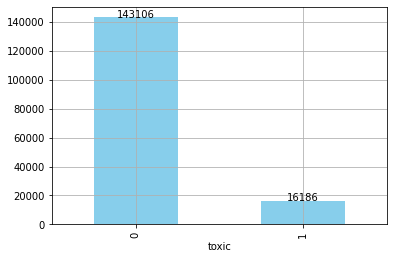

In [25]:
# сбор данных о количестве объектов каждого класса
toxic_counts = data['toxic'].value_counts()

# построение графика с учетом количества объектов каждого класса
fig, ax = plt.subplots()
bar_plot = toxic_counts.plot(kind='bar', color='skyblue', grid=True)
for i, v in enumerate(toxic_counts):
    ax.text(i, v + 10, str(v), color='black', ha='center')
plt.show();

Дисбаланс на графике очевиден (класс `0` — `143106` объектов, класс `1` — `16186` объектов). Существует мнение, что отрицательные комментарии люди пишут намного охотнее, а когда впечатления положительные, вроде бы и писать нечего. Однако такой дисбаланс может отразиться на качестве определения позитивных и негативных комментариев моделью. 

Балансировать будем только тренировочные данные, валидационные и тестовые оставим в исходном состоянии, чтобы избежать смещения оценки.

In [26]:
# выделим целевую переменную
features = data.drop('toxic', axis=1)
target = data['toxic']

In [27]:
# разделим данные на тренировочную (80%), валидационную (10%) и тестовую (10%) выборки
features_train, features_temp, target_train, target_temp = train_test_split(features, target, 
                                                                            test_size=0.2, random_state=RANDOM_STATE)
features_valid, features_test, target_valid, target_test = train_test_split(features_temp, target_temp, test_size=0.5,
                                                                            random_state=RANDOM_STATE)

In [28]:
# проверим разделение
print('Размер обучающей выборки:', features_train.shape)
print('Размер валидационной выборки:', features_valid.shape)
print('Размер тестовой выборки:', features_test.shape)
print()
print('Размер целевой переменной обучающей выборки:', target_train.shape)
print('Размер целевой переменной валидационной выборки:', target_valid.shape)
print('Размер целевой переменной тестовой выборки:', target_test.shape)

Размер обучающей выборки: (127433, 1)
Размер валидационной выборки: (15929, 1)
Размер тестовой выборки: (15930, 1)

Размер целевой переменной обучающей выборки: (127433,)
Размер целевой переменной валидационной выборки: (15929,)
Размер целевой переменной тестовой выборки: (15930,)


In [29]:
# проверим соотношение классов 0/1 в target_train:
class_0 = [i for i, x in enumerate(target_train) if x == 0]
count_0 = len(class_0)

class_1 = [i for i, x in enumerate(target_train) if x == 1]
count_1 = len(class_1)

print('Доля объектов класса 1 в обучающей выборке:', len(class_1) / (len(class_1) + len(class_0)))
print('Доля объектов класса 0 в обучающей выборке:', len(class_0) / (len(class_0) + len(class_1)))

Доля объектов класса 1 в обучающей выборке: 0.10189668296281183
Доля объектов класса 0 в обучающей выборке: 0.8981033170371882


In [30]:
# уменьшим кол-во объектов класса 0 в обучающей выборке
data_train = data.iloc[target_train.index]

target_train_0 = data_train[data_train['toxic'] == 0]['toxic']
target_train_1 = data_train[data_train['toxic'] == 1]['toxic']

# выберем соотношение классов 4 к 1
target_train_0_resample = target_train_0.sample(n=target_train_1.shape[0] * 4,
                                                replace=False, random_state=RANDOM_STATE)
target_train_resample = pd.concat([target_train_0_resample, target_train_1])

features_train_resample = data.iloc[target_train_resample.index]

# перемешаем данные
features_train_resample, target_train_resample = shuffle(features_train_resample,
                                                         target_train_resample,
                                                         random_state=RANDOM_STATE)

features_train_resample = features_train_resample['text']

print('Соотношение объектов классов 0 и 1 в обучающей выборке:')
print(target_train_resample.value_counts(normalize=True))
print('-----')
print(features_train_resample.shape)
print(target_train_resample.shape)

Соотношение объектов классов 0 и 1 в обучающей выборке:
toxic
0    0.8
1    0.2
Name: proportion, dtype: float64
-----
(64925,)
(64925,)


In [31]:
# изменю переменные, чтобы не переписывать дальнейший код
features_train = features_train_resample
target_train = target_train_resample

**Вывод**

При подготовке данных был удален неинформативный столбец `Unnamed: 0`, выполнена очистка комментариев, их токенизация и лемматизация, удалены стоп-слова, обработан дисбаланс классов в целевой переменной обучающей выборки.

## Обучение

Инициализируем TfidfVectorizer для преобразования текстовых данных в векторы TF-IDF. И преобразуем текстовые данные в векторы TF-IDF для обучающей, валидационной и тестовой выборки.

In [37]:
count_tf_idf = TfidfVectorizer()

In [39]:
tf_idf_train = count_tf_idf.fit_transform(features_train.squeeze())
tf_idf_valid = count_tf_idf.transform(features_valid.squeeze())
tf_idf_test = count_tf_idf.transform(features_test.squeeze())

Обучим модели `LogisticRegression()`, `DecisionTreeClassifier()` и `LGBMClassifier()`.

### LogisticRegression()

In [40]:
%time
# обучим модель LogisticRegression
lr = LogisticRegression(random_state=RANDOM_STATE)
parameters = {'penalty': ['l1', 'l2'],
              'C': [10, 100],
              'solver': ['liblinear'],
              'max_iter': [100, 200],
              'class_weight': [None]}

clf = GridSearchCV(lr, param_grid=parameters, scoring='f1', cv=None)

clf.fit(tf_idf_train, target_train)
predictions_train = clf.predict(tf_idf_train)

f1_lr_tr = f1_score(target_train, predictions_train)
print('F1 метрика LogisticRegression на обучающей выборке:', f1_lr_tr)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs
F1 метрика LogisticRegression на обучающей выборке: 0.9779930259589307


In [41]:
# лучшие параметры
clf.best_params_ 

{'C': 10,
 'class_weight': None,
 'max_iter': 100,
 'penalty': 'l1',
 'solver': 'liblinear'}

In [42]:
# предсказание на валидационной выборке
predictions_valid = clf.predict(tf_idf_valid)

# оценка модели на валидационной выборке
f1_lr_val = f1_score(target_valid, predictions_valid)
print('F1 метрика LogisticRegression на валидационной выборке:', f1_lr_val)

F1 метрика LogisticRegression на валидационной выборке: 0.7683789603199016


### DecisionTreeClassifier()

In [43]:
%time
# обучим модель DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=RANDOM_STATE)

parameters = {'criterion': ['gini', 'entropy'],
              'max_depth': [None, 10, 20],
              'min_samples_split': [2, 5, 10]}

clf = GridSearchCV(dt, param_grid=parameters, scoring='f1', cv=None)

clf.fit(tf_idf_train, target_train)

predictions_train = clf.predict(tf_idf_train)

f1_dt_tr = f1_score(target_train, predictions_train)
print('F1 метрика DecisionTreeClassifier на обучающей выборке:', f1_dt_tr)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs
F1 метрика DecisionTreeClassifier на обучающей выборке: 0.9771256931608133


In [44]:
# предсказание на валидационной выборке
predictions_valid = clf.predict(tf_idf_valid)

# оценка модели на валидационной выборке
f1_dt_val = f1_score(target_valid, predictions_valid)
print('F1 метрика DecisionTreeClassifier на валидационной выборке:', f1_dt_val)

F1 метрика DecisionTreeClassifier на валидационной выборке: 0.6819708846584547


### LGBMClassifier()

In [45]:
%time
# обучим модель LGBMClassifier
lgbm = LGBMClassifier(random_state=RANDOM_STATE)

lgbm.fit(tf_idf_train, target_train)
predictions_train = lgbm.predict(tf_idf_train)

f1_lgbm_tr = f1_score(target_train, predictions_train)
print('F1 метрика LGBMClassifier на обучающей выборке:', f1_lgbm_tr)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs
F1 метрика LGBMClassifier на обучающей выборке: 0.8356718602048722


In [46]:
# предсказание на валидационной выборке
predictions_valid = lgbm.predict(tf_idf_valid)
f1_lgbm_val = f1_score(target_valid, predictions_valid)

# оценка модели на валидационной выборке
print('F1 метрика LightGBM на валидационной выборке:', f1_lgbm_val)

F1 метрика LightGBM на валидационной выборке: 0.7744565217391305


Создадим сводную таблицу, чтобы определить лучшую модель на основе *F1* метрики, полученной на валидационной выборке.

In [47]:
# создание таблицы с метриками F1
data = {
    'Модель': ['Logistic Regression', 'Decision Tree', 'LGBM Classifier'],
    'F1 на обучающей выборке': [f1_lr_tr, f1_dt_tr, f1_lgbm_tr],
    'F1 на валидационной выборке': [f1_lr_val, f1_dt_val, f1_lgbm_val]
}

df = pd.DataFrame(data)
print(df)

                Модель  F1 на обучающей выборке  F1 на валидационной выборке
0  Logistic Regression                 0.977993                     0.768379
1        Decision Tree                 0.977126                     0.681971
2      LGBM Classifier                 0.835672                     0.774457


-------------------------

<u>**Тестирование лучшей модели**</u> (выбрана по *F1* метрике на валидационной выборке)

Модель `LGBMClassifier()` получила на валидационной выборке значение *F1* метрики `0.77`, поэтому среди всех моделей она выбрана лучшей. Немного отстает модель `LogisticRegression()` со значением *F1* метрики `0.76` на валидационной выборке.

Протестируем модель `LGBMClassifier()` на тестовой выборке.

In [49]:
%time
# предсказание на тестовой выборке
predictions_test = lgbm.predict(tf_idf_test)

# вычисление F1 метрики на тестовой выборке
f1_lgbm_test = f1_score(target_test, predictions_test)
print('F1 метрика LightGBM на тестовой выборке:', f1_lgbm_test)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs
F1 метрика LightGBM на тестовой выборке: 0.7724510465901419


**Вывод**

Модель `LGBMClassifier()` на валидационной выборке получила значение метрики *F1* — `0.77`, на тестовой выборке имеем аналогичное значение. Полученное значение удовлетворяет условию задачи (значение метрики качества *F1* должно быть не меньше `0.75`).

## Выводы

В наше распоряжение поступил набор данных с разметкой о токсичности правок. В соответствии с задачей требовалось обучить модель классифицировать комментарии на позитивные и негативные. Построенная модель должна иметь значение метрики качества *F1* не меньше `0.75`.

Данные были изучены и обработаны: был удален неинформативный столбец `Unnamed: 0`, выполнена очистка комментариев, их токенизация и лемматизация, удалены стоп-слова, обработан дисбаланс классов в целевой переменной. Пропуски и явные дубликаты не обнаружены.

Было обучено три модели: `LogisticRegression()`, `DecisionTreeClassifier()` и `LGBMClassifier()`. За кулисами пробовала и другие модели, но то ядро умирало, то просто выпонение ноутбука падало по неясным причинам после нескольких часов обучения модели.

На валидационной выборке модели получили следующие значения метрики *F1*:

*  Logistic Regression — 0.768379
*  Decision Tree — 0.681971
*  LGBM Classifier — 0.774457

Исходя из полученных значений, лучшей была выбрана модель `LGBMClassifier()` с самым высоким значением, равным `0.77`. Поэтому на тестовых данных проверялась только эта модель, здесь она получила значение метрики *F1*, равное также `0.77`, данное значение удовлетворяет поставленной задаче, чтобы значение метрики качества *F1* было не меньше `0.75`. Кроме того, ее преимуществом в данном случае является и то, что она довольно-таки быстро обучается (по сравнению с представленными моделями и моделями, которые были проверены, но не попали в данный проект).

Таким образом, можно рекомендовать данную модель для реализации данного проекта.